# Nicholas Tam Analysis

## Research Question/Interests
Research question: Given the tree dataset, how would we want to arrange the types of trees to be planted in certain locations, such that they could survive and significantly improve the ecosystmem

Given the research question, it would be ideal toanalyze relevant properties, such as the relative sizes of each location and the proportions of planted trees for each species .

In [1]:
import altair as alt
import pandas as pd
from toolz.curried import pipe
import os
from pygbif import species

# Create a new data transformer that stores the files in a directory
def json_dir(data, data_dir='altairdata'):
    os.makedirs(data_dir, exist_ok=True)
    return pipe(data, alt.to_json(filename=data_dir + '/{prefix}-{hash}.{extension}') )

# Register and enable the new transformer
alt.data_transformers.register('json_dir', json_dir)
alt.data_transformers.enable('json_dir')

# Handle large data sets (default shows only 5000)
# See here: https://altair-viz.github.io/user_guide/data_transformers.html
alt.data_transformers.disable_max_rows()

alt.renderers.enable('jupyterlab')

RendererRegistry.enable('jupyterlab')

## Initial Dataset
- `TREE_ID`, `CIVIC_NUMBER`, `ON_STREET_BLOCK`, and `HEIGHT_RANGE_ID` are all treated as integers, `DIAMETER` is treated as a float, and the rest are treated as objects.
- `CULTIVAR_NAME`, `NEIGHBOURHOOD_NAME`, and `DATE_PLANTED` are columns that have missing values.
- `public_trees.nunique()` displays the number of unique values for each column. Notably, there is a discrepancy between the number of unique values for `HEIGHT_RANGE_ID` and the number of unique values for `HEIGHT_RANGE`. Since `GENUS_NAME` and `SPECIES_NAME`, along with `ON_STREET` and `ON_STREET_BLOCK`, are related to each other, the number of unique values may be more accurate if they are combined.
- `public_trees.describe()` is used to further display that `TREE_ID`, `CIVIC_NUMBER`, `ON_STREET_BLOCK`, `HEIGHT_RANGE_ID` and `DIAMETER` are all treated as numeric, when only `HEIGHT_RANGE_ID` and `DIAMETER` could be numeric, along with the latitude and longitude from `geo_point_2d`..

In [2]:
import sys
sys.path.append("../../code")
import data_clean

public_trees = pd.read_csv("../../data/raw/public-trees.csv", delimiter=";")

In [3]:
display(public_trees.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181501 entries, 0 to 181500
Data columns (total 17 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   TREE_ID             181501 non-null  int64  
 1   CIVIC_NUMBER        181501 non-null  int64  
 2   STD_STREET          181501 non-null  object 
 3   GENUS_NAME          181501 non-null  object 
 4   SPECIES_NAME        181501 non-null  object 
 5   CULTIVAR_NAME       80725 non-null   object 
 6   COMMON_NAME         181501 non-null  object 
 7   ON_STREET_BLOCK     181501 non-null  int64  
 8   ON_STREET           181501 non-null  object 
 9   NEIGHBOURHOOD_NAME  177573 non-null  object 
 10  STREET_SIDE_NAME    181501 non-null  object 
 11  HEIGHT_RANGE_ID     181501 non-null  int64  
 12  HEIGHT_RANGE        181501 non-null  object 
 13  DIAMETER            181501 non-null  float64
 14  DATE_PLANTED        74159 non-null   object 
 15  Geom                181501 non-nul

None

In [4]:
cols_with_nan = public_trees.columns[public_trees.isna().any()].tolist()
display(cols_with_nan)

['CULTIVAR_NAME', 'NEIGHBOURHOOD_NAME', 'DATE_PLANTED']

In [5]:
display(public_trees.nunique())

TREE_ID               181501
CIVIC_NUMBER            8339
STD_STREET               814
GENUS_NAME               169
SPECIES_NAME             539
CULTIVAR_NAME            607
COMMON_NAME             1297
ON_STREET_BLOCK          189
ON_STREET                822
NEIGHBOURHOOD_NAME        22
STREET_SIDE_NAME           6
HEIGHT_RANGE_ID           11
HEIGHT_RANGE               9
DIAMETER                 490
DATE_PLANTED            4570
Geom                  181372
geo_point_2d          181372
dtype: int64

## Cleaning
- `HEIGHT_RANGE` is set to be an ordinal attribute, with the order provided in `priority_order`.
- `TREE_ID`, `CIVIC_NUMBER`, and `ON_STREET_BLOCK` are set to be categorical attributes.
- Earlier EDA provided `CULTIVAR_NAME`, `NEIGHBOURHOOD_NAME`, `DATE_PLANTED` as having NA values; `CULTIVAR_NAME` is filled with the corresponding `SPECIES_NAME`, `NEIGHBOURHOOD_NAME` has `NA` strings applied instead, and `DATE_PLANTED` is left with `None`.
- The latitude and longitude values were initially joined together in a single coordinate column `geo_point_2d`, and thus are split into new columns `LATITUDE` and `LONGITUDE`.
- The values `9`, `0` and `10` all correspond to `HEIGHT_RANGE == '>90'` and thus `0` and `10` are replaced with value `9`.
- `NOMENCLATURE` is a column derived from combining `GENUS_NAME` and `SPECIES_NAME` into 1 string.
- `ON_ADDRESS` is a column derived from combining `ON_STREET` and `ON_STREET_BLOCK` into 1 string.

In [6]:
public_trees_cleaned = data_clean.clean_public_trees(public_trees)
public_trees_cleaned.to_csv("../../data/processed/public_trees_cleaned.csv", index=False)

## Processed Data
- Upon loading `public_trees_cleaned.csv` in the future, need to set the attribute types for `HEIGHT_RANGE`, `TREE_ID`, `CIVIC_NUMBER`, and `ON_STREET_BLOCK`.

In [7]:
public_trees_cleaned = pd.read_csv("../../data/processed/public_trees_cleaned.csv")
priority_order = ['10-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90', '>90']
public_trees_cleaned['HEIGHT_RANGE'] = pd.Categorical(public_trees_cleaned['HEIGHT_RANGE'], categories=priority_order, ordered=True)
public_trees_cleaned[['TREE_ID', 'CIVIC_NUMBER', 'ON_STREET_BLOCK']] = public_trees_cleaned[['TREE_ID', 'CIVIC_NUMBER', 'ON_STREET_BLOCK']].astype(str)

public_trees_cleaned.head()

,TREE_ID,CIVIC_NUMBER,STD_STREET,GENUS_NAME,SPECIES_NAME,CULTIVAR_NAME,COMMON_NAME,ON_STREET_BLOCK,ON_STREET,NEIGHBOURHOOD_NAME,...,HEIGHT_RANGE_ID,HEIGHT_RANGE,DIAMETER,DATE_PLANTED,Geom,geo_point_2d,LATITUDE,LONGITUDE,NOMENCLATURE,ON_ADDRESS
0,229002,2128,E 54TH AV,FAGUS,SYLVATICA,DAWYCKII,DAWYCK'S BEECH,2100,E 54TH AV,VICTORIA-FRASERVIEW,...,2,20-30,3.0,2014-03-12,"{""coordinates"": [-123.06377300024464, 49.22020...","49.22020099919947, -123.06377300024464",49.220201,-123.063773,FAGUS SYLVATICA,2100 E 54TH AV VICTORIA-FRASERVIEW (EVEN)
1,229005,8443,FREMLIN ST,ACER,TRUNCATUM,PACIFIC SUNSET,PACIFIC SUNSET MAPLE,8400,FREMLIN ST,MARPOLE,...,3,30-40,12.0,2010-11-08,"{""coordinates"": [-123.12751900039063, 49.20967...","49.20967799914094, -123.12751900039063",49.209678,-123.127519,ACER TRUNCATUM,8400 FREMLIN ST MARPOLE (ODD)
2,229013,1407,W 59TH AV,PRUNUS,CERASIFERA,NIGRA,NIGHT PURPLE LEAF PLUM,7400,CARTIER ST,MARPOLE,...,1,10-20,3.0,2010-10-20,"{""coordinates"": [-123.13790199955884, 49.21762...","49.21762499869929, -123.13790199955884",49.217625,-123.137902,PRUNUS CERASIFERA,7400 CARTIER ST MARPOLE (ODD)
3,229015,489,W 2ND AV,PYRUS,CALLERYANA,CHANTICLEER,CHANTICLEER PEAR,400,W 2ND AV,MOUNT PLEASANT,...,1,10-20,3.0,2009-12-10,"{""coordinates"": [-123.11410500027938, 49.26698...","49.26698999931175, -123.11410500027938",49.266990,-123.114105,PYRUS CALLERYANA,400 W 2ND AV MOUNT PLEASANT (MED)
4,229016,489,W 2ND AV,PYRUS,CALLERYANA,CHANTICLEER,CHANTICLEER PEAR,400,W 2ND AV,MOUNT PLEASANT,...,1,10-20,3.0,2009-12-10,"{""coordinates"": [-123.11399200056373, 49.26704...","49.267045998933334, -123.11399200056373",49.267046,-123.113992,PYRUS CALLERYANA,400 W 2ND AV MOUNT PLEASANT (MED)


In [8]:
display(public_trees_cleaned.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181501 entries, 0 to 181500
Data columns (total 21 columns):
 #   Column              Non-Null Count   Dtype   
---  ------              --------------   -----   
 0   TREE_ID             181501 non-null  object  
 1   CIVIC_NUMBER        181501 non-null  object  
 2   STD_STREET          181501 non-null  object  
 3   GENUS_NAME          181501 non-null  object  
 4   SPECIES_NAME        181501 non-null  object  
 5   CULTIVAR_NAME       181501 non-null  object  
 6   COMMON_NAME         181501 non-null  object  
 7   ON_STREET_BLOCK     181501 non-null  object  
 8   ON_STREET           181501 non-null  object  
 9   NEIGHBOURHOOD_NAME  177573 non-null  object  
 10  STREET_SIDE_NAME    181501 non-null  object  
 11  HEIGHT_RANGE_ID     181501 non-null  int64   
 12  HEIGHT_RANGE        181501 non-null  category
 13  DIAMETER            181501 non-null  float64 
 14  DATE_PLANTED        74159 non-null   object  
 15  Geom             

None

In [9]:
display(public_trees_cleaned.nunique())

TREE_ID               181501
CIVIC_NUMBER            8339
STD_STREET               814
GENUS_NAME               169
SPECIES_NAME             539
CULTIVAR_NAME           1070
COMMON_NAME             1297
ON_STREET_BLOCK          189
ON_STREET                822
NEIGHBOURHOOD_NAME        22
STREET_SIDE_NAME           6
HEIGHT_RANGE_ID            9
HEIGHT_RANGE               9
DIAMETER                 490
DATE_PLANTED            4570
Geom                  181372
geo_point_2d          181372
LATITUDE              181368
LONGITUDE             181365
NOMENCLATURE             701
ON_ADDRESS             19269
dtype: int64

In [10]:
display(public_trees_cleaned.describe())

,HEIGHT_RANGE_ID,DIAMETER,LATITUDE,LONGITUDE
count,181501.000000,181501.000000,181501.000000,181501.000000
mean,2.997388,12.734885,49.248839,-123.107687
std,1.939766,10.201543,0.022868,0.048919
min,1.000000,0.000000,49.200203,-123.236684
25%,1.000000,4.000000,49.230403,-123.144378
50%,2.000000,10.000000,49.248475,-123.109569
75%,4.000000,18.000000,49.266611,-123.064573
max,9.000000,305.000000,49.312730,-123.023294


## EDA: Count of each `SPECIES_NAME` that have been planted
- `Planted_Count` for each species is derived by counting the number of rows with `DATE_PLANTED` filled for each tree species.
- `Proportion_Planted` derived from dividing `Planted_Count` by the total number of the given species.
- Would ideally want a reasonably large `Total_Count` value (at least 300) to mitigate the risk of having too few samples of each species to effectively measure and compare characteristics.
- Would also want `Proportion_Planted` to be within certain range of values (between 0.33 and 0.67) to mitigate the possibility that the obtained properties of planted trees are by random chance, and ensure that there are plenty of both planted and non-planted trees to compare against each other.
- Applied log-transform to `Total_Count` to make colored value range easier to interpret.
- Greater values of `Total_Count` generally provide less extreme values of `Proportion_Planted`.

In [11]:
species_planted_count = public_trees_cleaned[public_trees_cleaned['DATE_PLANTED'].notnull()].groupby('SPECIES_NAME').size().reset_index(name='Planted_Count')
species_total_count = public_trees_cleaned.groupby('SPECIES_NAME').size().reset_index(name='Total_Count')
species_summary = species_planted_count.merge(species_total_count, on='SPECIES_NAME')
species_summary['Proportion_Planted'] = species_summary['Planted_Count'] / species_summary['Total_Count']
# species_summary[(species_summary['Total_Count'] >= 300) & (species_summary['Proportion_Planted'] >= 0.33) & (species_summary['Proportion_Planted'] <= 0.67)]

/opt/anaconda3/lib/python3.12/site-packages/altair/utils/core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


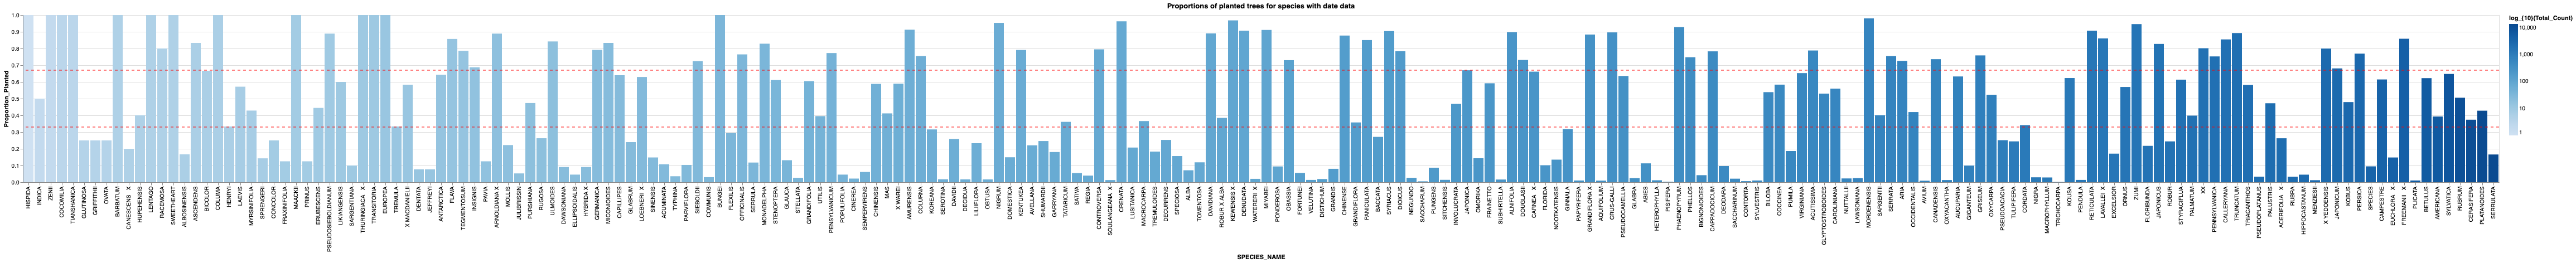

In [12]:
species_chart = alt.Chart(species_summary).mark_bar().encode(
    alt.X('SPECIES_NAME:N', sort='color'),
    alt.Y('Proportion_Planted:Q'),
    alt.Color('Total_Count', scale=alt.Scale(type='log'), title='log_{10}(Total_Count)'),
    alt.Tooltip(['Total_Count']),
).properties(
    title='Proportions of planted trees for species with date data',
)

horizontal_lines = alt.Chart(pd.DataFrame({
    'Proportion_Planted': [0.33, 0.67],
})).mark_rule(color='red', strokeDash=[5, 5]).encode(
    alt.Y('Proportion_Planted:Q'),
)

species_chart + horizontal_lines

## EDA: Scatterplot of `LATITUDE` against `LONGITUDE`
- Distribution of data points along axes of latitude and longitude.
- Provides an estimated "map" of the areas for each `NEIGHBOURHOOD_NAME` in Vancouver, and thus a better understanding of how tree density could be influenced for each area.
- Limited by the number of `NEIGHBOURHOOD_NAME` exceeding the number of colors
- Could be improved upon with `mark_geoshape()`, may require getting coordinate values that were removed in cleaning.

/opt/anaconda3/lib/python3.12/site-packages/altair/utils/core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/opt/anaconda3/lib/python3.12/site-packages/altair/utils/core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/opt/anaconda3/lib/python3.12/site-packages/altair/utils/core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/opt/anaconda3/lib/python3.12/site-packages/altair/utils/c

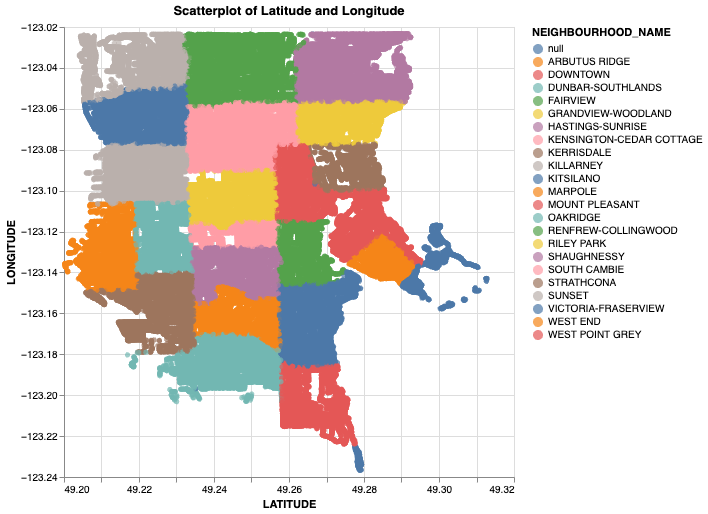

In [13]:
latvlong = alt.Chart(public_trees_cleaned).mark_circle().encode(
    alt.X('LATITUDE:Q', scale=alt.Scale(zero=False)),
    alt.Y('LONGITUDE:Q', scale=alt.Scale(zero=False)),
    alt.Color('NEIGHBOURHOOD_NAME:N'),
    alt.Tooltip(['NEIGHBOURHOOD_NAME']),
).properties(
    title='Scatterplot of Latitude and Longitude',
    width = 450, 
    height = 450
)
latvlong

## EDA: Boxplots of `DIAMETER` grouped by `HEIGHT_RANGE`
- Box plots of `DIAMETER` against `HEIGHT_RANGE`.
- For the most part, mean `DIAMETER` increases with `HEIGHT_RANGE`.
- Outliers for `DIAMETER` appear to be more frequent for lower `HEIGHT_RANGE` values, and less frequent for higher `HEIGHT_RANGE` values.

In [14]:
# public_trees_summary = public_trees_cleaned.groupby("HEIGHT_RANGE")["DIAMETER"].describe()
# upper_bound = max(public_trees_summary["75%"] + public_trees_summary["std"] * 3)
# filtered_data = public_trees_cleaned[public_trees_cleaned["DIAMETER"] <= upper_bound]

/opt/anaconda3/lib/python3.12/site-packages/altair/utils/core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/opt/anaconda3/lib/python3.12/site-packages/altair/utils/core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/opt/anaconda3/lib/python3.12/site-packages/altair/utils/core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/opt/anaconda3/lib/python3.12/site-packages/altair/utils/c

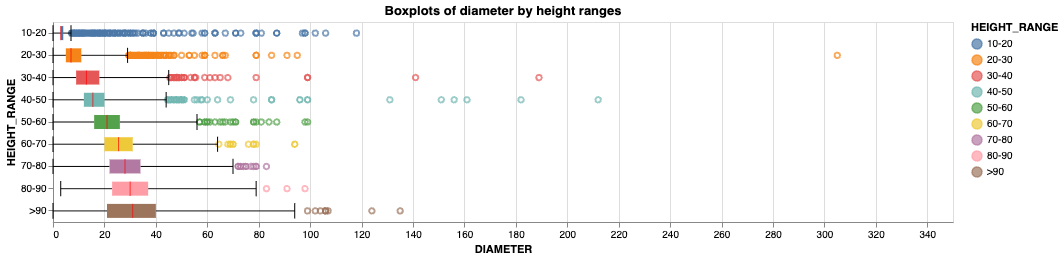

In [15]:
public_trees_box = alt.Chart(public_trees_cleaned).mark_boxplot(
    median={"color": "red"},
    extent=3,
    ticks= True,
).encode(
    # alt.X('DIAMETER:Q', scale=alt.Scale(zero=False, domain=[0, upper_bound + 10])),
    alt.X('DIAMETER:Q', scale=alt.Scale(zero=False)),
    alt.Y('HEIGHT_RANGE:N'),
    alt.Color('HEIGHT_RANGE:N'),
    # alt.Column('HEIGHT_RANGE:N'),
).properties(
    title='Boxplots of diameter by height ranges',
    width = 900, 
    height = 200
)
public_trees_box

## EDA: Number of `ON_STREET` grouped by `NEIGHBOURHOOD_NAME`
- Number of streets 

/opt/anaconda3/lib/python3.12/site-packages/altair/utils/core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


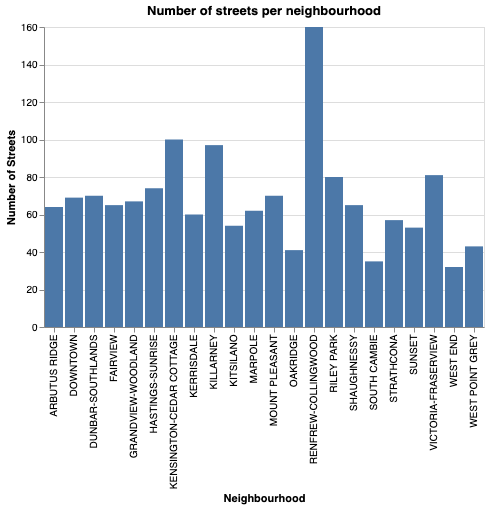

In [16]:
species_per_genus = public_trees_cleaned.groupby('NEIGHBOURHOOD_NAME')['ON_STREET'].nunique().reset_index()

species_per_genus_chart = alt.Chart(species_per_genus).mark_bar().encode(
    alt.X('NEIGHBOURHOOD_NAME:N', title='Neighbourhood'),
    alt.Y('ON_STREET:Q', title='Number of Streets'),
    alt.Tooltip(['NEIGHBOURHOOD_NAME', 'ON_STREET']),
).properties(
    title='Number of streets per neighbourhood',
)
species_per_genus_chart

## EDA: Proportions of `HEIGHT_RANGE` for each `NEIGHBOURHOOD_NAME`
- Normalized stacked bar plot for `HEIGHT_RANGE` proportions against `NEIGHBOURHOOD_NAME`.
- For the most part, the majority of `HEIGHT_RANGE` values are between `HEIGHT_RANGE == "10-20"` and `HEIGHT_RANGE == "30-40"`.

/var/folders/sp/136d3tf94ns_hpp_7z4mgphm0000gp/T/ipykernel_8186/2701962177.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  height_counts = public_trees_cleaned.groupby(['NEIGHBOURHOOD_NAME', 'HEIGHT_RANGE']).size().reset_index(name='Count')
/opt/anaconda3/lib/python3.12/site-packages/altair/utils/core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


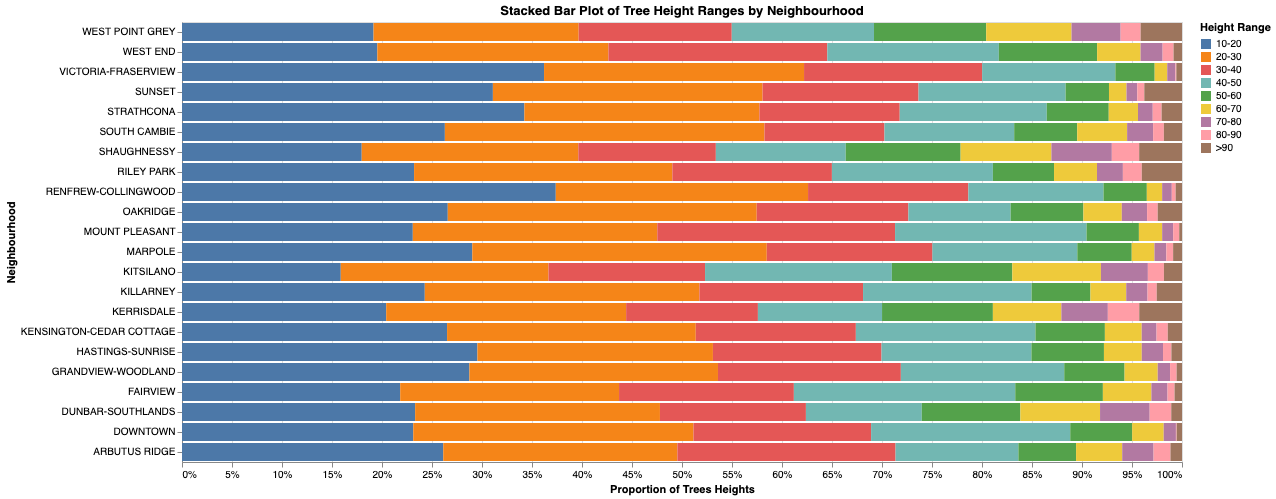

In [17]:
# Aggregate count of trees per neighbourhood and height range
height_counts = public_trees_cleaned.groupby(['NEIGHBOURHOOD_NAME', 'HEIGHT_RANGE']).size().reset_index(name='Count')

# Create the stacked bar chart
neighbour_height_stack = alt.Chart(height_counts).mark_bar().encode(
    alt.Y('NEIGHBOURHOOD_NAME:N', title='Neighbourhood', sort='-y'),  # Sort by count
    alt.X('Count:Q', title='Proportion of Trees Heights', stack='normalize'),
    alt.Color('HEIGHT_RANGE:N', title='Height Range'),  # Custom colors
    alt.Tooltip(['NEIGHBOURHOOD_NAME', 'HEIGHT_RANGE', 'Count']),
).properties(
    title='Stacked Bar Plot of Tree Height Ranges by Neighbourhood',
    width=1000
)

neighbour_height_stack